<a href="https://colab.research.google.com/github/xoreo/md/blob/master/Notebooks/Basic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Something you should know about me: I really dislike object oriented programming. Can't wait to write this in C.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [0]:
class Point:
  def __init__(self, x, y):
    self.x, self.y = x, y

In [0]:
PARTICLE_MASS = 1
EDGE_LEN = 5
N_PARTICLES = 25
PADDING = 2.0

LOWER_WINDOW = -0.5
UPPER_WINDOW = EDGE_LEN + 0.5

## Some notes on how this is implemented
Right now, the n_particles parameter for the Box2D constructor might not always be accurate to the current amount of particles in a Box2D at any given point in time. This is because of the way that the amount of particles are calculated. Right now, there will always be a perfect square number of particles in the box, just to make it easier for the particles to be equally spread out. This doesn't need to always be the case, but it is good for right now.

In [0]:
# Particle represents a singular particle.
class Particle:
  def __init__(
    self,
    index,
    mass=PARTICLE_MASS,
  ): 
    self.mass = mass
    self.index = index # Index in all related vectors
    # In order for acceleration to be zero, velocity must be constant.
    self.vel = Point(random.random() / 10, random.random() / 10)
    # self.vel = Point(2, 2)

  def kinetic_energy_x(self):
    return self.mass * (self.vel.x ** 2) * 0.5

  def kinetic_energy_y(self):
    return self.mass * (self.vel.y ** 2) * 0.5

# Box2D represents a two-dimensional box of particles.
class Box2D:
  def __init__(
      self,
      n_particles=N_PARTICLES,
      edge_len=EDGE_LEN,
      padding=PADDING,
  ):
    self.edge_len = edge_len
    self.ppr = int(np.sqrt(n_particles)) # Number of particles per row
    self.n_particles = self.ppr ** 2 # The number of particles.
    self.padding = padding

    '''
    self.positions:
     x  |  y 
    ---------
    ... | ...
    ---------
    indexed by self.positions[some_particle.index] -> numpy.array([x, y])
    '''
    self.positions = np.zeros(shape=(self.ppr ** 2, 2))

    '''
    self.particles:
    indexed by self.particles[index] -> Particle
    '''
    self.particles = np.empty(self.ppr ** 2, dtype=object)
    self.temps = [] # A history of the temperature of the system
    self.pressures = [] # A history of the pressure of the system
    self.time = 0 # The current time of the system
    
    self.populate()
  
  # populate populates the Box2D with a square number of equally-spaced particles.
  def populate(self):
    space = np.linspace(self.padding, self.ppr - self.padding, self.ppr)

    for row in range(0, space.size):   # [0, ppr)
      for col in range(0, space.size): # [0, ppr)
          index = self.ppr * col + row # Calc the C-style index for the vectors

          particle_x_pos = space[col]
          particle_y_pos = space[row]
          self.positions[index][0] = particle_x_pos
          self.positions[index][1] = particle_y_pos
          
          self.particles[index] = Particle(index)
  
  # calc_positions calculates the positions of the particles in the box.
  def calc_positions(self, delta_t):
    # I will vectorize this later, but I want to get it working first
    for particle in self.particles:
      # Made these just for readability
      x_pos = self.positions[particle.index][0]
      y_pos = self.positions[particle.index][1]
      
      # Collision detection
      if x_pos + particle.vel.x >= self.edge_len:
        particle.vel.x *= -1
        self.positions[particle.index][0] = self.edge_len
      if x_pos + particle.vel.x <= 0:
        particle.vel.x *= -1
        self.positions[particle.index][0] = 0

      if y_pos + particle.vel.y >= self.edge_len:
        particle.vel.y *= -1
        self.positions[particle.index][1] = self.edge_len 
      if y_pos + particle.vel.y <= 0:
        particle.vel.y *= -1
        self.positions[particle.index][1] = 0

      self.positions[particle.index][0] += particle.vel.x * delta_t # x
      self.positions[particle.index][1] += particle.vel.y * delta_t # y
     
  # calc_temps calculates the temperature of the system.
  def calc_temp(self):
    kinetic_energies_x = np.zeros(self.n_particles)
    kinetic_energies_y = np.zeros(self.n_particles)
    for i in range(self.n_particles):
      kinetic_energies_x[i] = self.particles[i].kinetic_energy_x()
      kinetic_energies_y[i] = self.particles[i].kinetic_energy_y()

    # I am averaging because I think that temperature is the "average kinetic energy of a system"
    self.temps.append(
        np.average([
          np.average(kinetic_energies_x),
          np.average(kinetic_energies_y),
        ])
    )

  # calc_pressure calculates the pressure of the system.
  def calc_pressure(self):
    # sum(F) / perimeter
    self.pressures.append(0)

  # step changes time, updating the positions of the particles in the box.
  def step(self):
    self.time += 1
    self.calc_positions(1)
    self.calc_temp()
    self.calc_pressure()
  
  # step_n steps n times.
  def step_n(self, n=1, show=True):
    for i in range(n):
      self.step()
      if show:
        self.show()

  # show shows a graph of the current positions of the particles in the box.
  def show(self):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    particles = axes[0]
    temperature = axes[1]
    pressure = axes[2]

    # -- Particles plot -- #
    particles.scatter(
      self.positions[:,0], # x
      self.positions[:,1], # y
    )
    particles.set_title('Particles')

    rect = patches.Rectangle(
      (0, 0), self.edge_len, self.edge_len,
      linewidth = 1,
      edgecolor = 'b',
      facecolor = 'none'
    )

    particles.add_patch(rect)

    particles.set_xlim([LOWER_WINDOW, UPPER_WINDOW])
    particles.set_ylim([LOWER_WINDOW, UPPER_WINDOW])

    # -- Temperature plot -- #
    temperature.plot(
        np.linspace(0, self.time, len(self.temps)), # x axis
        self.temps, # y axis
    )
    temperature.set_title('Temperature')

    # -- Pressure plot -- #
    pressure.plot(
      np.linspace(0, self.time, len(self.pressures)),
      self.pressures,
    )
    pressure.set_title('Pressure')

    plt.show()

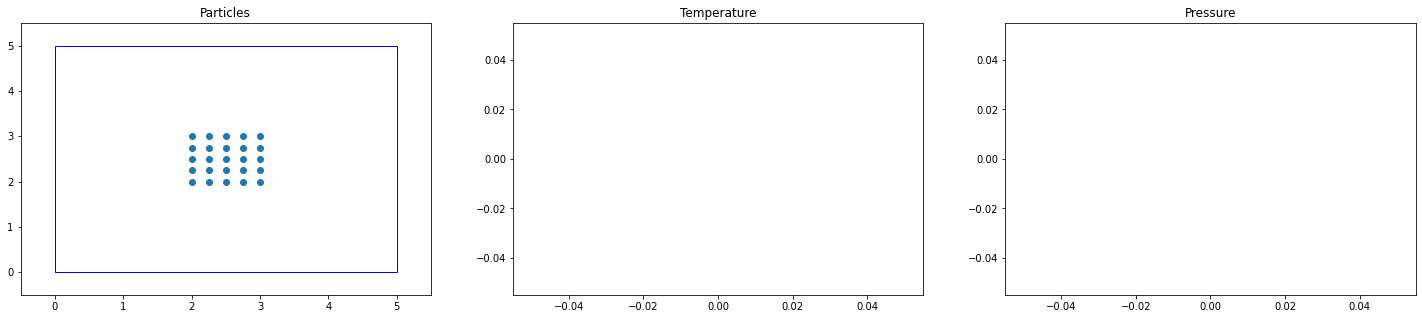

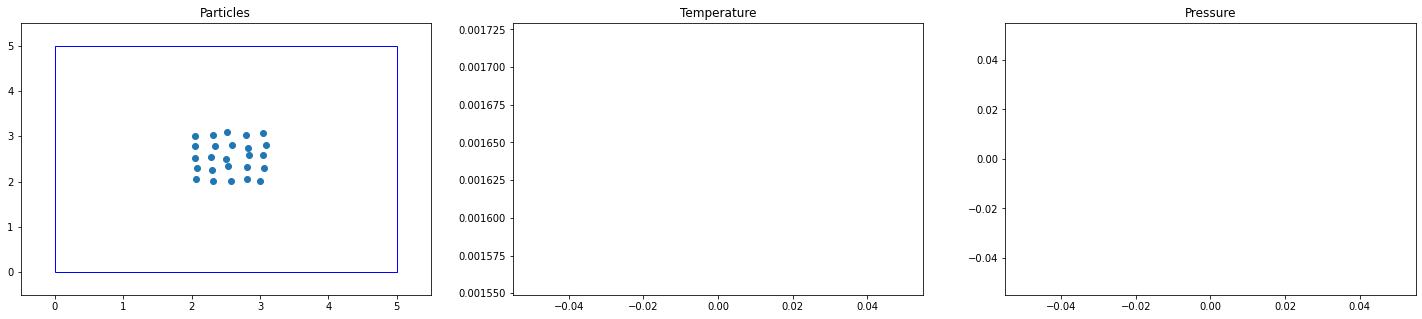

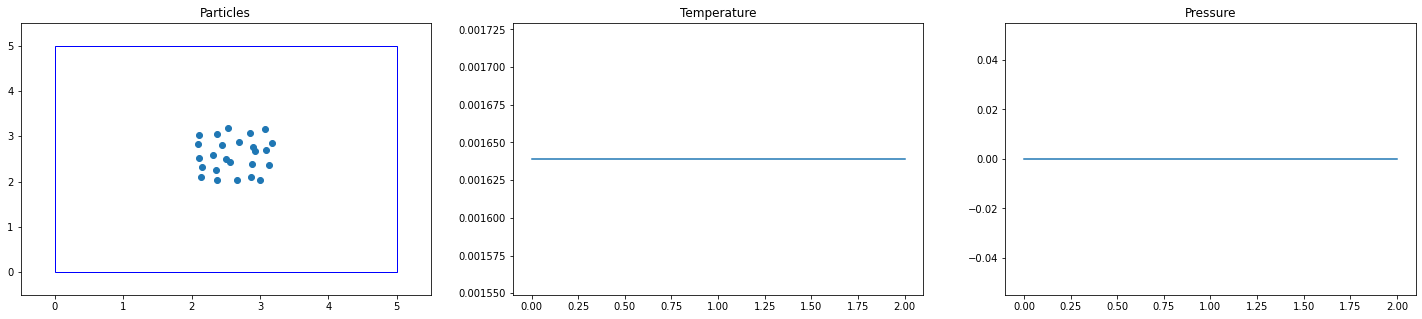

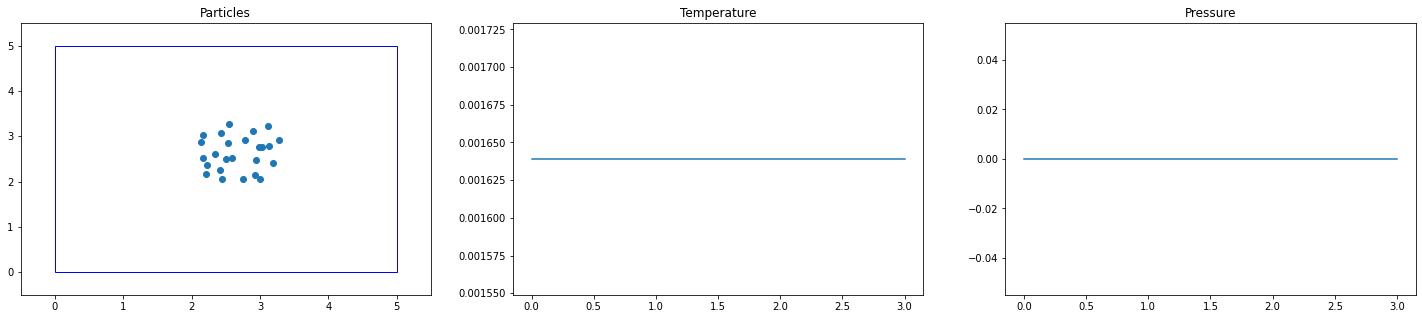

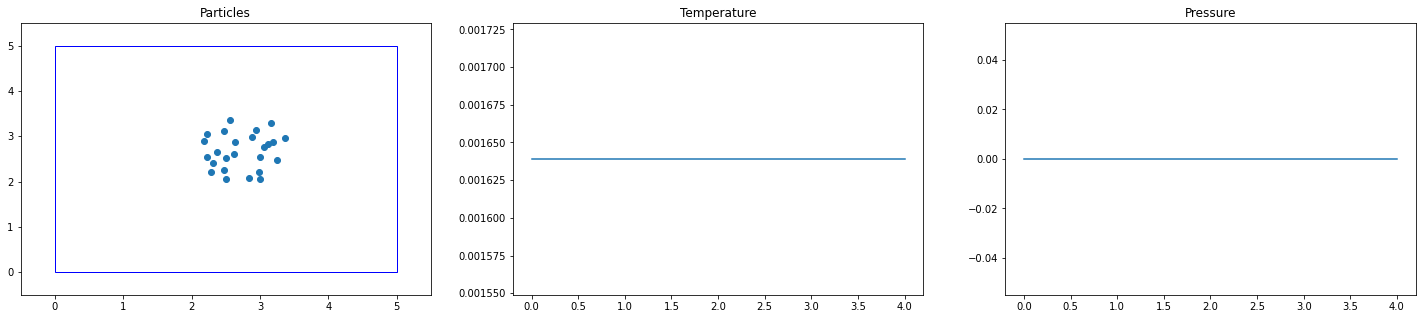

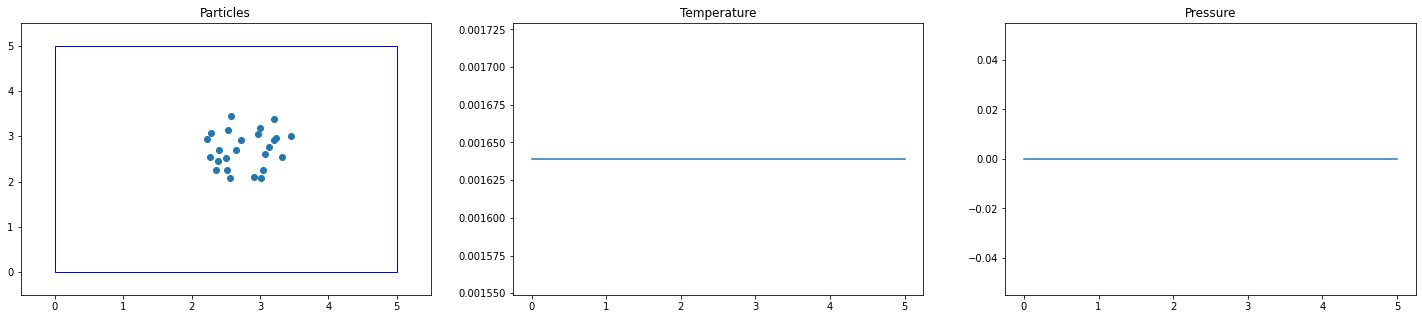

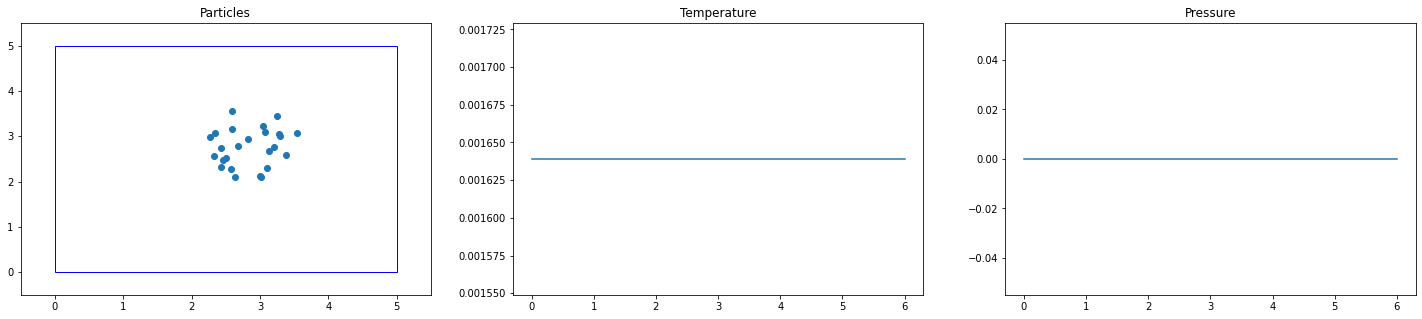

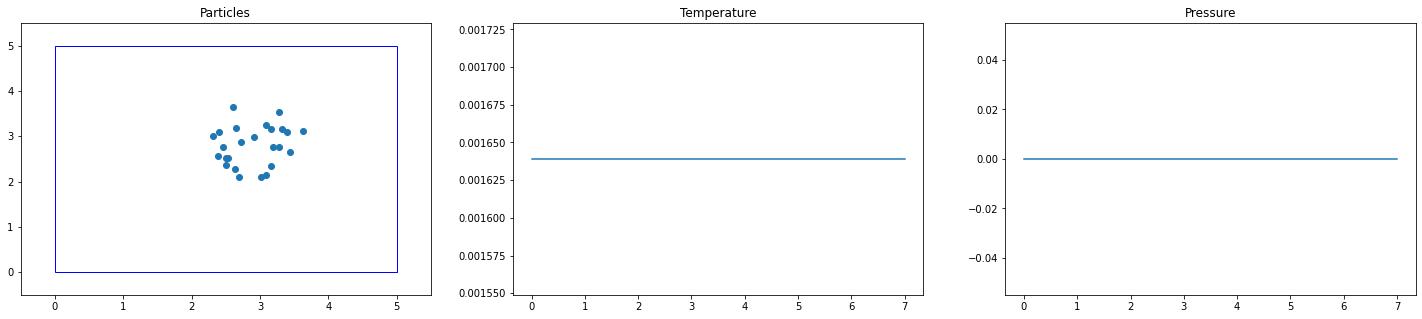

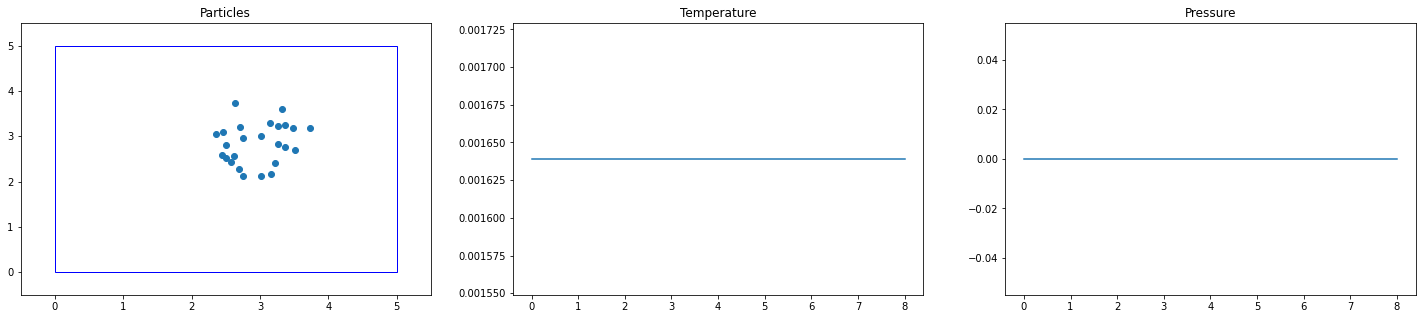

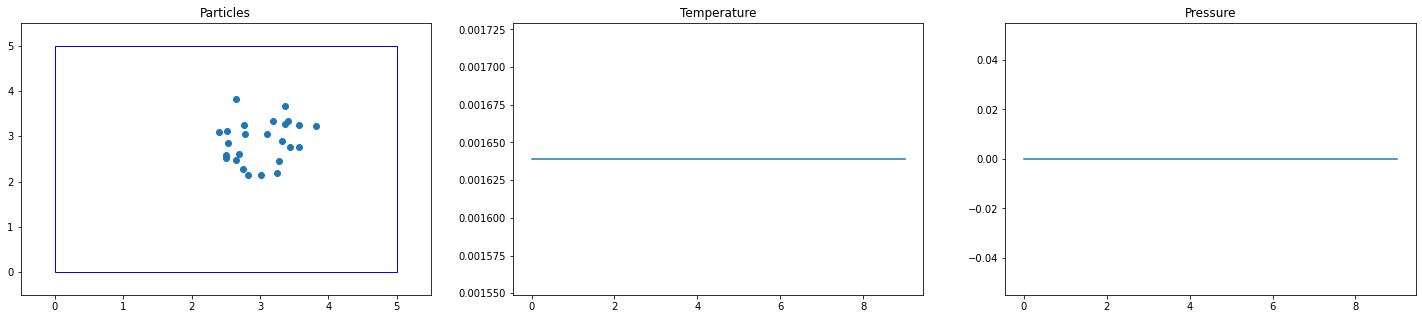

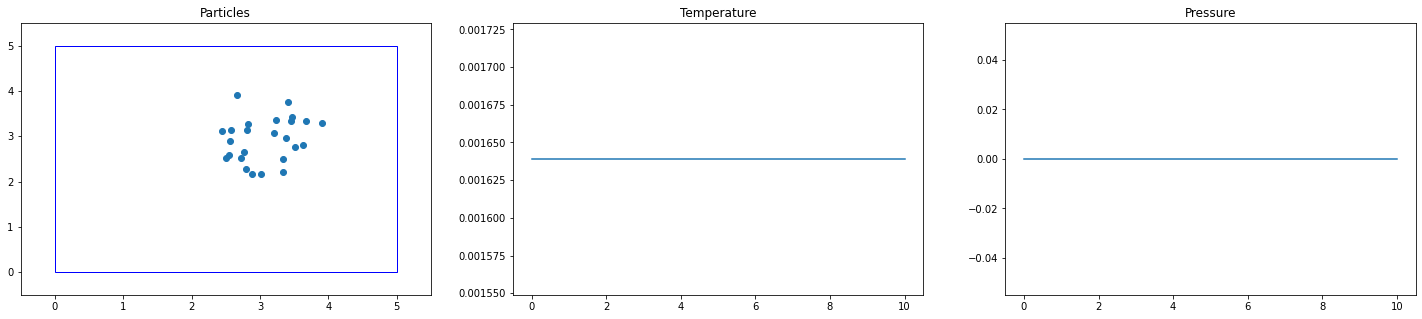

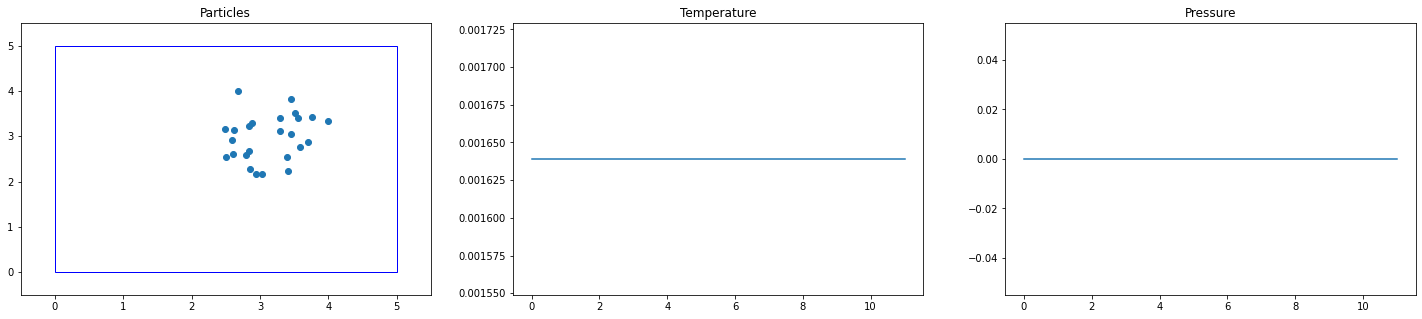

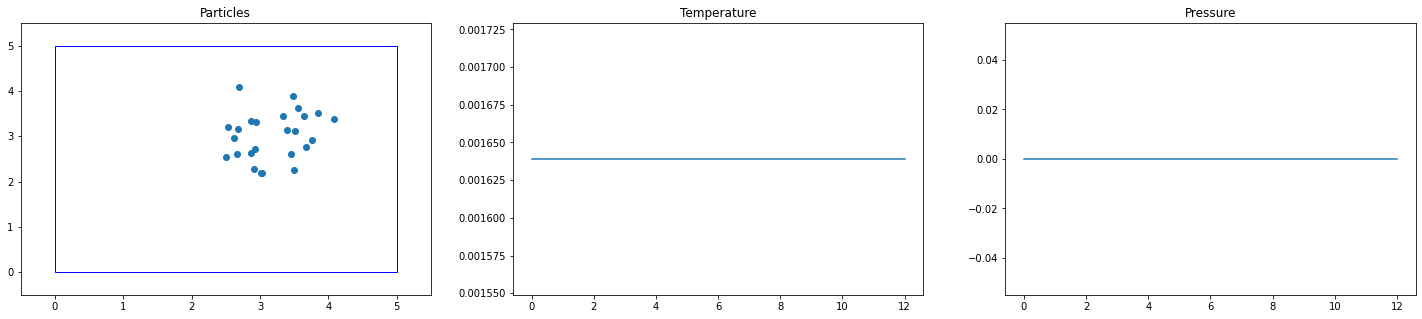

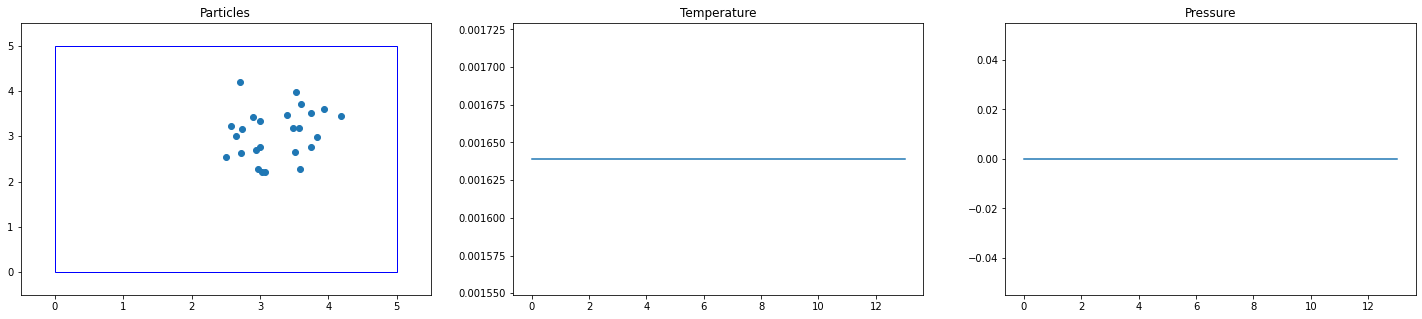

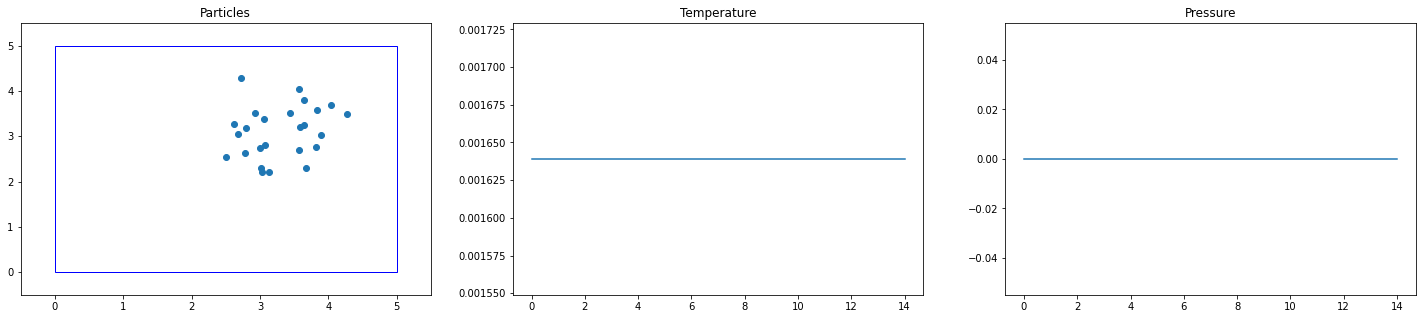

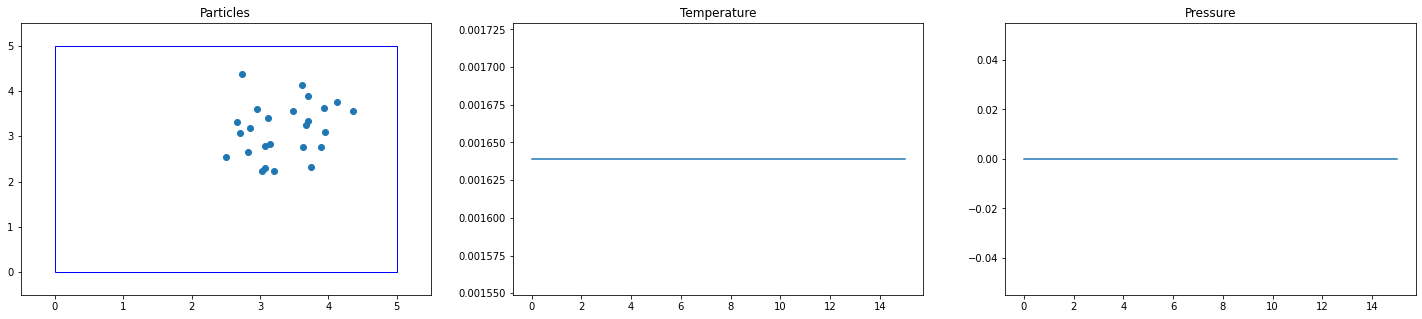

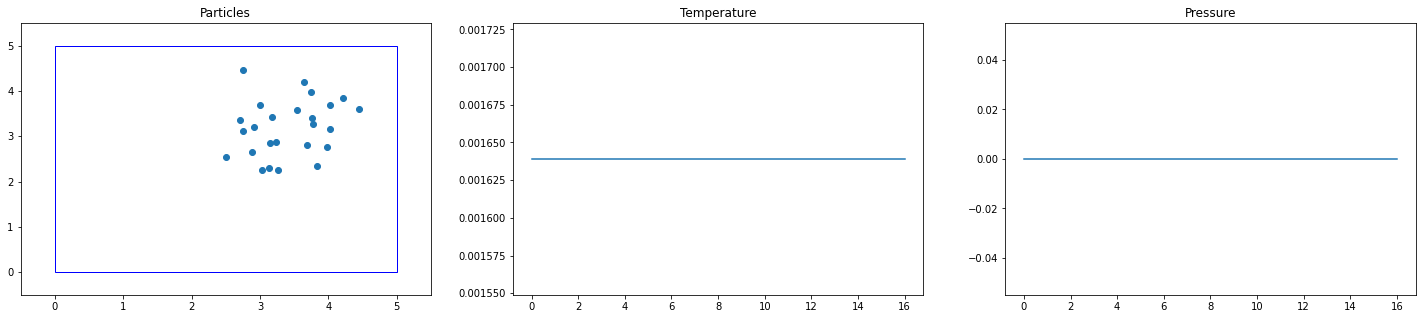

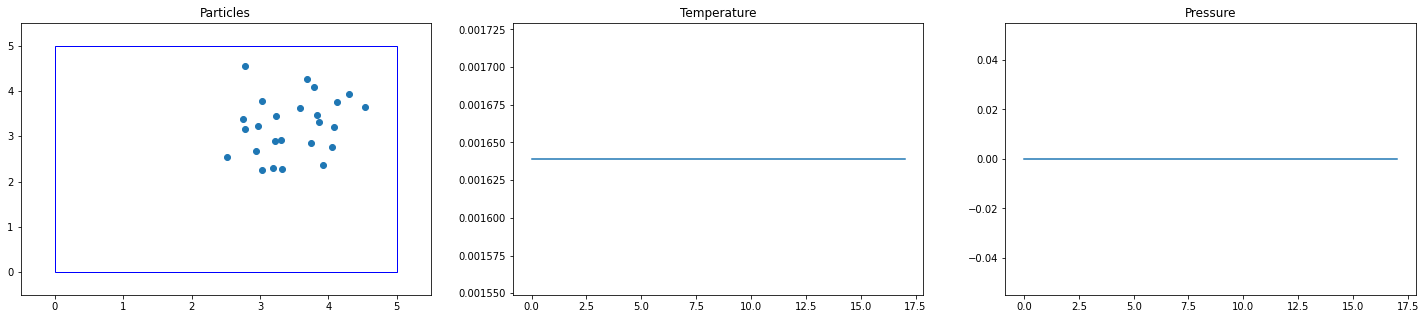

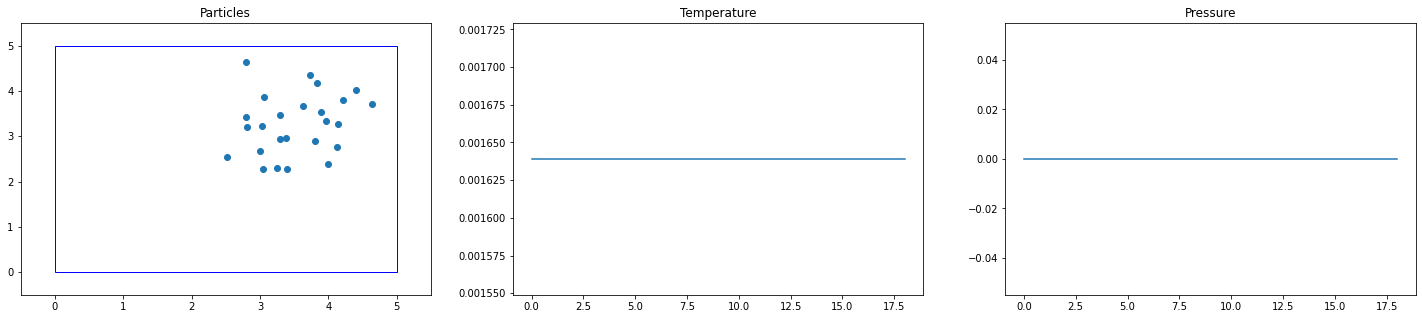

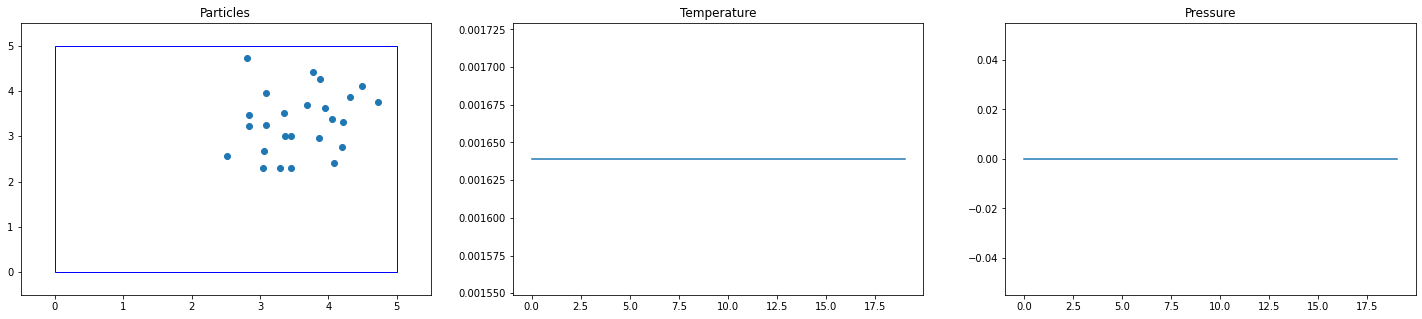

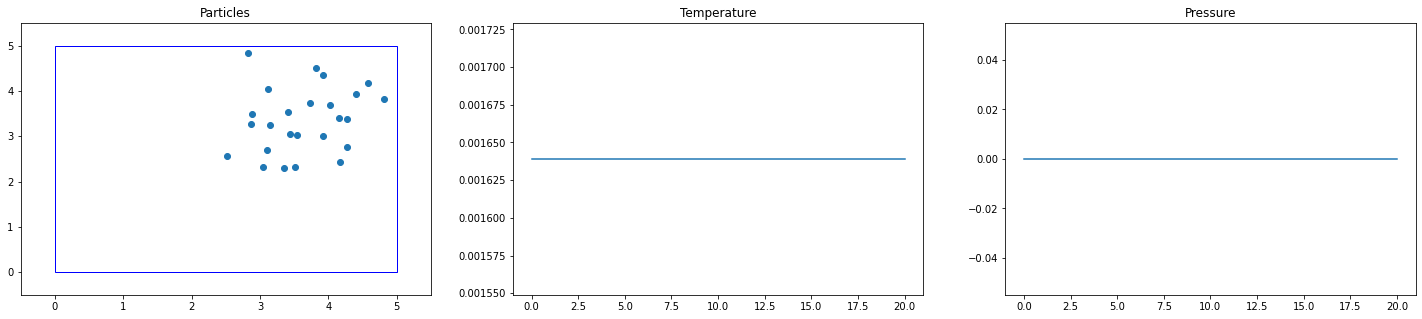

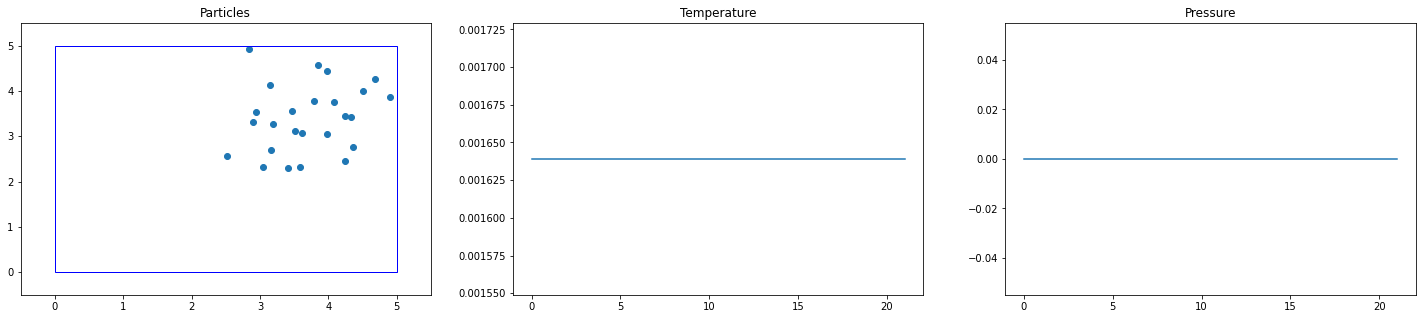

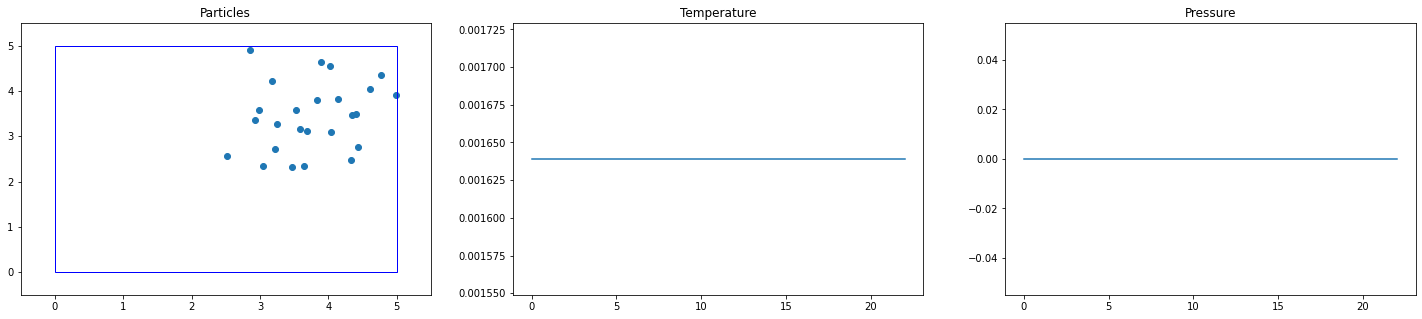

KeyboardInterrupt: ignored

In [65]:
box = Box2D()

box.show()

box.step_n(1000)

print(f'time: {box.time}')